<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler # для масштабирования количественных признаков
from sklearn.preprocessing import OrdinalEncoder # порядковое кодирование
from sklearn.model_selection import train_test_split # деление на 2 выборки
from sklearn.model_selection import GridSearchCV # для поиска оптимальных параметров
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error # для расчета MSE и RMSE
from sklearn.linear_model import LinearRegression # линейная регрессия
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# загрузим данные
try:
    df = pd.read_csv('/datasets/taxi.csv', sep=',', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('taxi.csv', sep=',', index_col=[0], parse_dates=[0])

In [3]:
# проверим данные на всякое нехорошее. использую функцию, которой пользовался в прошлых проектах
names= [df]

def info_func(names):
    for name in names:
        df_temp = pd.DataFrame(name)
        display(df_temp.head(10))
        display(df_temp.info())
        display('Кол-во НАНов:', df_temp.isna().sum())
        display('Статистика:', df_temp.describe())
    return
info_func(names)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

'Кол-во НАНов:'

num_orders    0
dtype: int64

'Статистика:'

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [4]:
# сделаем ресемпл по часам
df = df.resample('1H').sum()
display(df.head())
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Количество данных не увеличилось драмматически, так что можно приступать к анализу. Проверять дубликаты бессмысленно, т.к. столбец с датами - иднекс, а количество заказов может повторяться в разные дни/часы/минуты

## Анализ

In [5]:
# проверим ряд на монотонность
df.index.is_monotonic

True

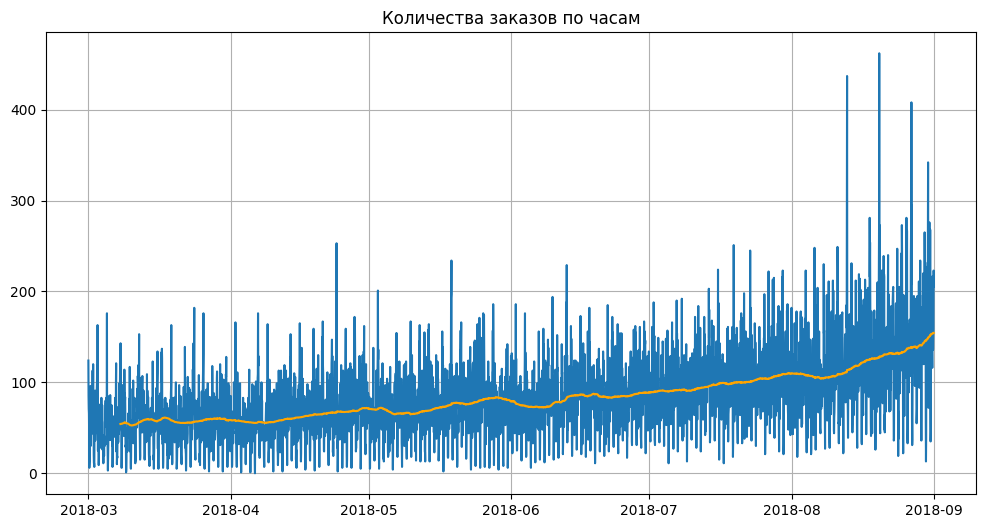

In [6]:
# просто так не верим, можем и посмотреть
rolling_mean = df.rolling(24*7).mean() # за неделю

plt.figure(figsize=(12,6))
plt.title("Количества заказов по часам")

plt.plot(df, label="Количество заказов")
plt.plot(rolling_mean, "g", label="Среднее количество заказов", color='orange')
plt.grid(True)

По характеру скользящего среднего можно судить, что в ряде присутствует сезонность. Связано это либо с ухудшением погодных условий, либо с изменением структуры предпочтений заказчиков (возможно приезжают туристы).

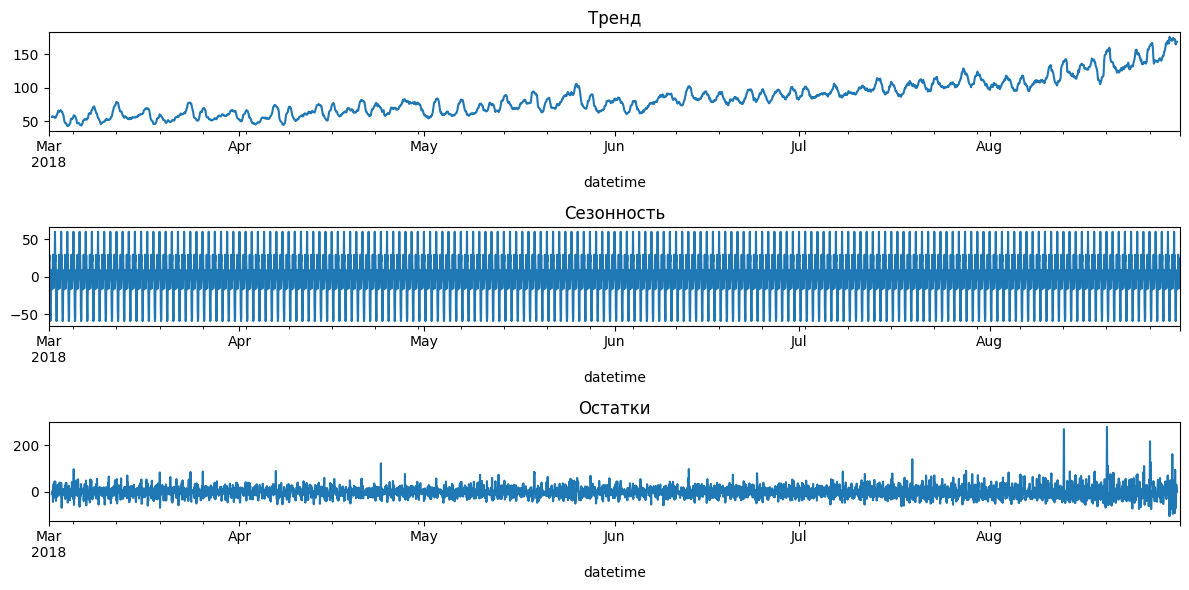

In [7]:
# декомпозируем ряд на составляющие
decomposed = seasonal_decompose(df) 

plt.figure(figsize=(12, 6))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

С трендом угадано точно, сезонность выглядит странно.

<AxesSubplot:title={'center':'Сезонность в течении дня'}, xlabel='datetime'>

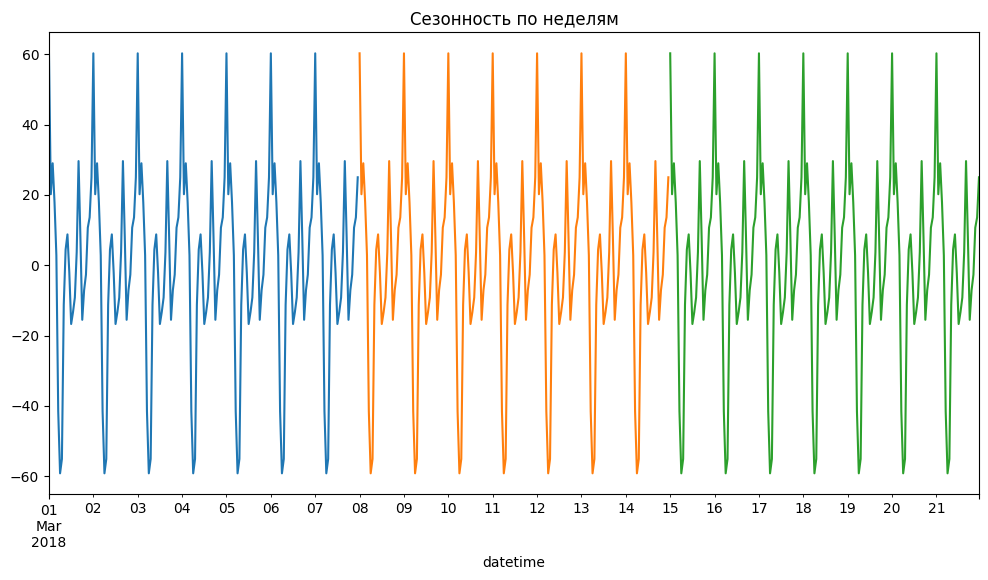

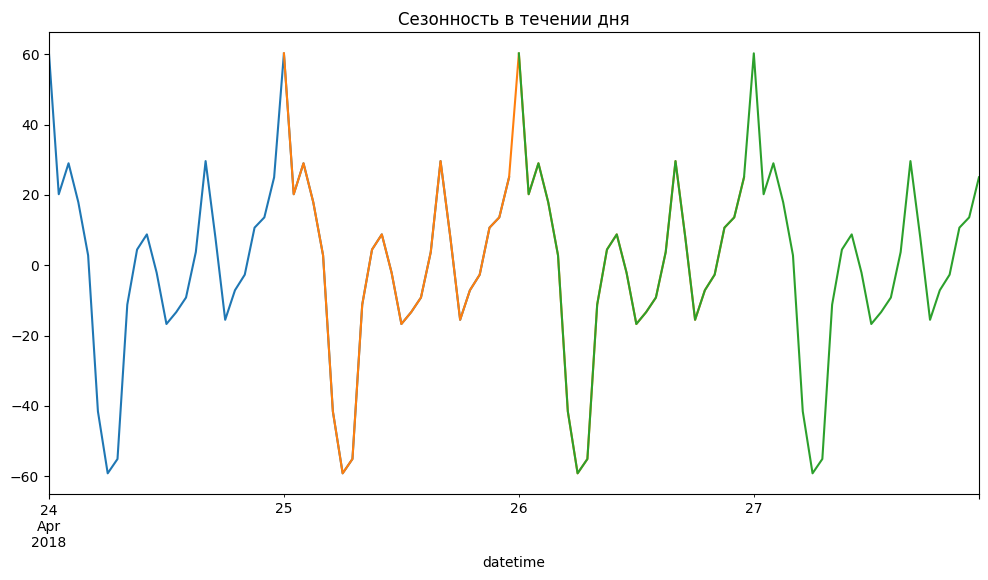

In [8]:
plt.figure(figsize=(12,6))
plt.title("Сезонность по неделям")
decomposed.seasonal['2018-03-01':'2018-03-7'].plot(ax=plt.gca())
decomposed.seasonal['2018-03-08':'2018-03-14'].plot(ax=plt.gca())
decomposed.seasonal['2018-03-15':'2018-03-21'].plot(ax=plt.gca())

plt.figure(figsize=(12,6))
plt.title('Сезонность в течении дня')           
decomposed.seasonal['2018-04-24':'2018-04-25'].plot(ax=plt.gca())        
decomposed.seasonal['2018-04-25':'2018-04-26'].plot(ax=plt.gca()) 
decomposed.seasonal['2018-04-26':'2018-04-27'].plot(ax=plt.gca())

Внутри дня заказы также распределяются неравномерно, но одинаково изо дня в день. Но вряд ли это не норма. Можем говорить о стационарности временного ряда

### Вывод
Итак, особых проблем с данными обнаружить не удалось, все непонятности объясняемы:
* Сезонность объясняется неравномерностью заказов в течение одного дня. В ночные часы заказов меньше, ближе к вечеру - число заказов растёт
* Общий тренд растёт, что может объясняться изменениями в структуре предпочтений пассажиров, которые меняются в течение календарного года. Также тренд имеет более сложную зависимость от времени (квадраичная или экспоненциальная, сложно оценить по днной выборке). Для нашей задачи будем считать его линейным (предсказания нам нужны всего на час вперёд). Также, чтобы побороться с зашумленностью тренда, будем использовать скользящее среднее размером в несколько часов
* По визуальным признакам ряд является стационарным и монотонным. Можно переходить к подготовке выборок и обучению моделей.


## Обучение

### Подготовка признаков

Разделим данные для обучения, попробуем подобрать лучшую модель. Скользящую среднюю возьмём равную суткам, чтобы сгладить колебания в течение дня. Лаг - равный неделе, чтобы исключить влияние общего тренда

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data 


In [10]:
# Зададим максимальный лаг на одну неделю
df1 = make_features(df, 24*7, 24)
df1.head(10)

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,1,3,5,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,1,3,6,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#теперь разделим выборки
train, test = train_test_split(df1, test_size=0.1, shuffle=False, random_state = 12345)

print('Размер обучающей выборки: ', train.shape)
print('Размер тестовой выборки: ', test.shape)

Размер обучающей выборки:  (3974, 173)
Размер тестовой выборки:  (442, 173)


In [12]:
# удалим пропуски в обучающей выборке. А в тестовой нужно?
train = train.dropna()
train.shape

(3806, 173)

In [13]:
# теперь отделим target от features
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)

target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

print('Размер таблицы признаков обучающей выборки:', features_train.shape)
print('Размер таблицы признаков тестовой выборки:', features_test.shape)

Размер таблицы признаков обучающей выборки: (3806, 172)
Размер таблицы признаков тестовой выборки: (442, 172)


In [14]:
# сделаем скорер для RMSE
def rmse_score (target, predictions):
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse
scorer = make_scorer(rmse_score, greater_is_better=False)

In [15]:
# кросс-валидация во временных рядах немного отличается от обычной, используется специальный метод, чтобы не допустить утечки целевого признака
tscv = TimeSeriesSplit(n_splits=5)

На это можно считать подготовку к обучению оконченной. Будем подбирать модели и гиперпараметры. С помощью RandomSearchCV (grid убил в прошлом проекте), протестим линейную регрессию, случайный лес и LGBM

### Линейная регрессия

In [16]:
lr = LinearRegression()
lr_parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
lr_grid = RandomizedSearchCV(lr, lr_parameters, cv=tscv, scoring=scorer, verbose=5, n_jobs=-1)
lr_grid.fit(features_train, target_train)
print("RMSE линейной регрессии составляет ", lr_grid.best_score_)
print('Наилучшие подобранные параметры для линейной регрессии')
lr_grid.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
RMSE линейной регрессии составляет  -22.462810460338442
Наилучшие подобранные параметры для линейной регрессии


{'normalize': True, 'fit_intercept': False}

### Случайный лес

In [17]:
forest = RandomForestRegressor(random_state=12345)
forest_parameters = {'n_estimators': range(30, 151, 10),
                 'max_depth': range(1,15)}
forest_grid = RandomizedSearchCV(forest, forest_parameters, cv=tscv, 
                                 scoring=scorer, verbose=5, n_jobs=-1)
forest_grid.fit(features_train, target_train)
print("RMSE для случайного леса составляет ", forest_grid.best_score_)
print('Наилучшие подобранные параметры для случайного леса')
print(forest_grid.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RMSE для случайного леса составляет  -22.906761447637304
Наилучшие подобранные параметры для случайного леса
{'n_estimators': 130, 'max_depth': 10}


### LGBM

In [18]:
lgbm = LGBMRegressor(random_state=12345)
    
lgbm_parameters = {'n_estimators': [50, 100, 500],
              'num_leaves': [21, 31, 41], 
              'learning_rate':[0.01, .04, 0.06]}

lgbm_grid = RandomizedSearchCV(lgbm, lgbm_parameters,
                         cv=tscv, verbose=5, scoring=scorer)

lgbm_grid.fit(features_train, target_train)

print("RMSE для LGBM составляет ", lgbm_grid.best_score_)


print('Наилучшие подобранные параметры для LGBM')
print(lgbm_grid.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.04, n_estimators=500, num_leaves=21;, score=-19.363 total time=   0.2s
[CV 2/5] END learning_rate=0.04, n_estimators=500, num_leaves=21;, score=-21.331 total time=   0.3s
[CV 3/5] END learning_rate=0.04, n_estimators=500, num_leaves=21;, score=-21.761 total time=   0.4s
[CV 4/5] END learning_rate=0.04, n_estimators=500, num_leaves=21;, score=-21.956 total time=   0.4s
[CV 5/5] END learning_rate=0.04, n_estimators=500, num_leaves=21;, score=-29.533 total time=   0.5s
[CV 1/5] END learning_rate=0.04, n_estimators=500, num_leaves=41;, score=-19.610 total time=   0.3s
[CV 2/5] END learning_rate=0.04, n_estimators=500, num_leaves=41;, score=-21.873 total time=   0.8s
[CV 3/5] END learning_rate=0.04, n_estimators=500, num_leaves=41;, score=-21.900 total time=   1.0s
[CV 4/5] END learning_rate=0.04, n_estimators=500, num_leaves=41;, score=-21.833 total time=   1.0s
[CV 5/5] END learning_rate=0.04, n_esti

## Тестирование

Лучшей моделью на обучающей выборке оказалось модель линейной регрессии. Проверим данные на тестовой

In [19]:
lr = LinearRegression(fit_intercept = False, normalize = True)
lr.fit(features_train, target_train)
predicted_test = lr.predict(features_test)
print('RMSE на тестовой выборке: ', rmse_score(target_test, predicted_test).round(2))

RMSE на тестовой выборке:  34.53


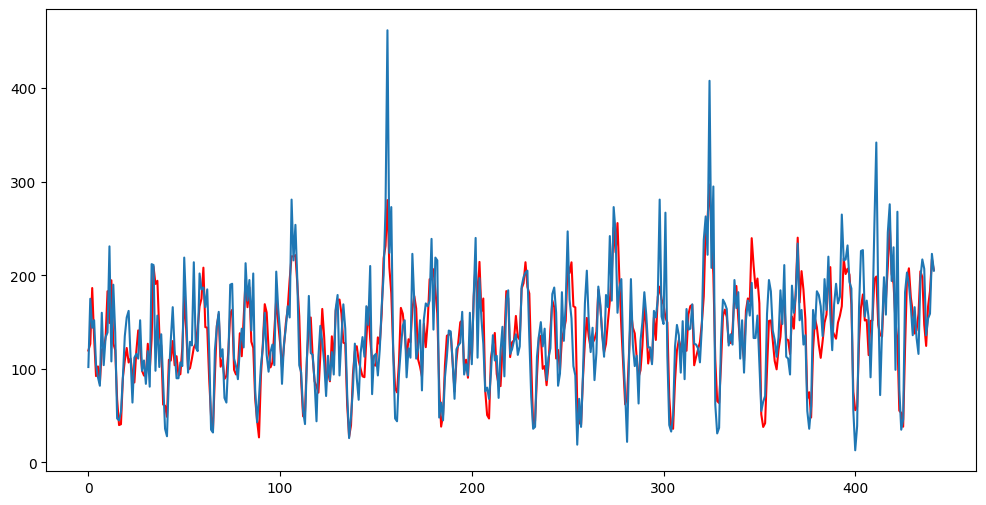

In [20]:
# Посмотрим визуально на качество предсказаний
plt.figure(figsize=(12, 6))
plt.plot(predicted_test, "r", label="Предсказания")
plt.plot(target_test.values, label="Истинные значения")

Показатели на тестовой выборке значительно ухудшились, однако, вряд ли стоит ожидать лучших показетелей от других моделей, порог RMSE=48 был преодолён. В данном случае, предлагаю оставить линейную регрессию. Во всяком случае, она достаточно быстро работает